In [1]:
import numpy as np
import pandas as pd 
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import fnmatch
import re

from ArapucaRoutineMainFunctions import *

In [2]:
base_path = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results'
#base_path = '/Users/bordoni/protoDUNE/XeDoping/testfiles'
file_path = os.path.join(base_path,'*.dat')

file_name_list =  glob.glob(file_path) 

file_name_list


['/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt7988_mod603_ch9.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt7988_mod603_ch8.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt11976_mod603_ch9.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt11976_mod603_ch8.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt7988_mod603_ch11.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt7988_mod603_ch10.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt11976_mod603_ch0.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt11976_mod603_ch1.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt11976_mod603_ch3.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt11976_mod603_ch2.dat',
 '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/run11103_evt11976_mod603_

In [3]:
file_name_dict = [parse_file_name(base_path, f) for f in file_name_list]

In [4]:
runlist = [ r['run_number'] for r in file_name_dict ]
runlist = list(set(runlist))

print('Full list of runs to process : \n', runlist )

Full list of runs to process : 
 ['11103']


In [5]:
for r in runlist[:1]:
    print('loading files for run ', r)
    df_list = create_dataset_list(file_name_dict, r)

    df_list_proc = doPreProcessing(df_list)

    # compute average waveform (raw! )
    df_av_wf = do_average_wf(df_list_proc)


    # compute single pe for calibration
    df_average_spe = do_average_singlepe(df_list_proc).to_frame()
    df_average_spe.reset_index(inplace = True)
    tmp = df_average_spe.pivot(index='Run number', columns='Ch', values='pe area')
    


    df_calib = tmp.div(tmp[0], axis = 0)
    df_calib = df_calib.T.stack(level=0).to_frame(name='f_cal').reset_index()


    #combine datasets (done in two steps)
    df_av_wf = pd.merge(df_av_wf, df_average_spe, left_on=['Run number', 'Ch'], right_on=['Run number', 'Ch'])
    df_av_wf = pd.merge(df_av_wf, df_calib, left_on=['Run number', 'Ch'], right_on=['Run number', 'Ch'])

    #produce a calibrated dataset 
    df_av_wf_cal = calibrate_av_wf(df_av_wf)

    df_integral_calib = df_av_wf_cal.groupby(['Run number']).sum()


loading files for run  11103
Run  11103   has for channel  0    2 files
Run  11103   has for channel  1    2 files
Run  11103   has for channel  2    2 files
Run  11103   has for channel  3    2 files
Run  11103   has for channel  4    2 files
Run  11103   has for channel  5    2 files
Run  11103   has for channel  6    2 files
Run  11103   has for channel  7    2 files
Run  11103   has for channel  8    2 files
Run  11103   has for channel  9    2 files
Run  11103   has for channel  10    2 files
Run  11103   has for channel  11    2 files
loaded  12 channels for this run
preparing dataframe for channel :  1
preparing dataframe for channel :  2
preparing dataframe for channel :  3
preparing dataframe for channel :  4
preparing dataframe for channel :  5
preparing dataframe for channel :  6
preparing dataframe for channel :  7
preparing dataframe for channel :  8
preparing dataframe for channel :  9
preparing dataframe for channel :  10
preparing dataframe for channel :  11
preparing d

In [6]:
df_ch0 = df_list_proc[0].copy()


In [7]:
df_ch0['max'] = df_ch0[rowin].max(axis=1, skipna = True)
df_ch0['Integral'] = df_ch0[rowin].sum(axis=1)
df_ch0.head(10)


,Ch,Run number,Evt number,0,1,2,3,4,5,6,...,2023,Saturated,Pedestal,hasSignal,n pe,pe height,pe width,pe area,max,Integral
0,0,11103,7982,11103.0,1.0,7982.0,603.0,48.0,0.0,264.0,...,1.136667,False,1578.53,False,0.0,0.0,0.0,0.0,2.170000,615.936667
1,0,11103,8003,11103.0,1.0,8003.0,603.0,48.0,0.0,264.0,...,-0.790000,False,1578.99,False,0.0,0.0,0.0,0.0,1.610000,-650.023333
2,0,11103,8005,11103.0,1.0,8005.0,603.0,48.0,0.0,264.0,...,0.803333,False,1578.83,False,0.0,0.0,0.0,0.0,1.636667,-227.896667
3,0,11103,8007,11103.0,1.0,8007.0,603.0,48.0,0.0,264.0,...,0.916667,False,1578.65,False,0.0,0.0,0.0,0.0,1.816667,373.616667
4,0,11103,8009,11103.0,1.0,8009.0,603.0,48.0,0.0,264.0,...,-0.080000,False,1578.18,False,0.0,0.0,0.0,0.0,2.986667,924.386667
5,0,11103,8011,11103.0,1.0,8011.0,603.0,48.0,0.0,264.0,...,0.833333,False,1578.50,False,0.0,0.0,0.0,0.0,1.900000,566.266667
6,0,11103,8013,11103.0,1.0,8013.0,603.0,48.0,0.0,264.0,...,0.570000,False,1578.13,False,0.0,0.0,0.0,0.0,2.170000,597.436667
7,0,11103,8015,11103.0,1.0,8015.0,603.0,48.0,0.0,264.0,...,-0.613333,False,1578.98,False,0.0,0.0,0.0,0.0,1.453333,-480.046667
8,0,11103,8017,11103.0,1.0,8017.0,603.0,48.0,0.0,264.0,...,0.926667,False,1578.64,False,0.0,0.0,0.0,0.0,2.060000,176.160000
9,0,11103,8019,11103.0,1.0,8019.0,603.0,48.0,0.0,264.0,...,0.770000,False,1577.83,False,0.0,0.0,0.0,0.0,3.136667,1889.136667


In [9]:
df_tmp = df_ch0.loc[ (df_ch0['Saturated'] == False ) & (df_ch0['hasSignal'] == True )]
df_tmp.head(20)

,Ch,Run number,Evt number,0,1,2,3,4,5,6,...,2023,Saturated,Pedestal,hasSignal,n pe,pe height,pe width,pe area,max,Integral
52,0,11103,8205,11103.0,1.0,8205.0,603.0,48.0,0.0,264.0,...,2.243333,False,1577.39,True,0.0,0.000000,0.000000,0.000000,18.376667,4100.710000
53,0,11103,8207,11103.0,1.0,8207.0,603.0,48.0,0.0,264.0,...,-0.516667,False,1578.45,True,0.0,0.000000,0.000000,0.000000,70.550000,18544.083333
65,0,11103,8251,11103.0,1.0,8251.0,603.0,48.0,0.0,264.0,...,5.040000,False,1577.96,True,0.0,0.000000,0.000000,0.000000,46.340000,13146.773333
67,0,11103,8255,11103.0,1.0,8255.0,603.0,48.0,0.0,264.0,...,-1.233333,False,1578.60,True,0.0,0.000000,0.000000,0.000000,16.300000,824.900000
68,0,11103,8257,11103.0,1.0,8257.0,603.0,48.0,0.0,264.0,...,0.630000,False,1577.37,True,0.0,0.000000,0.000000,0.000000,21.330000,7540.163333
72,0,11103,8285,11103.0,1.0,8285.0,603.0,48.0,0.0,264.0,...,0.336667,False,1577.23,True,1.0,8.403333,93.030769,544.343333,16.736667,3956.203333
74,0,11103,8289,11103.0,1.0,8289.0,603.0,48.0,0.0,264.0,...,0.900000,False,1577.80,True,0.0,0.000000,0.000000,0.000000,62.566667,7682.466667
78,0,11103,8297,11103.0,1.0,8297.0,603.0,48.0,0.0,264.0,...,1.426667,False,1576.64,True,0.0,0.000000,0.000000,0.000000,28.693333,5109.026667
79,0,11103,8299,11103.0,1.0,8299.0,603.0,48.0,0.0,264.0,...,-0.463333,False,1577.83,True,0.0,0.000000,0.000000,0.000000,22.303333,2431.236667
80,0,11103,8301,11103.0,1.0,8301.0,603.0,48.0,0.0,264.0,...,0.136667,False,1578.33,True,0.0,0.000000,0.000000,0.000000,53.403333,9439.236667


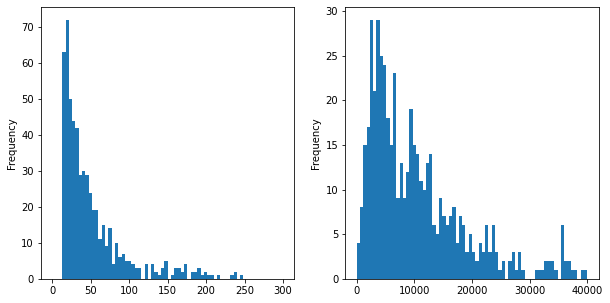

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(121)
df_tmp['max'].plot(kind = 'hist', bins = 70, range=(0,300)) 
plt.subplot(122)
df_tmp['Integral'].plot(kind = 'hist', bins = 70, range=(0,40000)) 
plt.show()

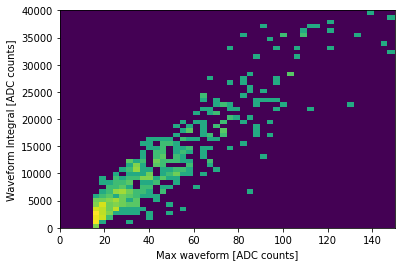

In [11]:
import matplotlib.colors as mcolors

plt.hist2d(df_tmp['max'], df_tmp['Integral'], 
           [50,50], range=[[0,150],[0,40000]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))
plt.xlabel('Max waveform [ADC counts]')
plt.ylabel('Waveform Integral [ADC counts]')

plt.show()



In [12]:
def estimate_gaus_param(X, multivar=False):
    mean = np.mean(X, axis=0)
    
    if multivar:
        cov = 1/float(len(X)) * np.dot( (X - mean).T , X-mean)
    else:
        cov = np.diag(np.var(X, axis=0))
    return mean,cov



def plot_contours(X, mean, cov):
    
    X1range = np.arange(np.min(X[:,0]),np.max(X[:,0]),5)
    X2range = np.arange(np.min(X[:,1]),np.max(X[:,1]),50)

    X1mesh, X2mesh = np.meshgrid(X1range, X2range)
    
    coord_list = [ np.array([X0,X1]) for X0, X1 in zip(np.ravel(X1mesh), np.ravel(X2mesh)) ]
    Z = multivariate_normal.pdf( coord_list , mean=mean, cov=cov)
    Z = Z.reshape(X1mesh.shape)
    
    #cont_levels = [10**exp for exp in range(-50,0,3)]
    sigma = np.sqrt(np.diag(cov))
    nsigma = np.array([mu+n*sigma for n in range(1,3)[::-1]])
    
    cont_levels = multivariate_normal.pdf( nsigma , mean=mu, cov=cov)    
    cs = plt.contour(X1mesh, X2mesh, Z, 10, levels=cont_levels, colors=('blue', 'yellow', 'orange', 'red' ))
   
    #plt.clabel(cs, fmt='%g', inline=1, fontsize=10)

    fmt = {}
    strs = ['$1 \sigma$', '$2 \sigma$', '$3 \sigma$', '$4 \sigma$', '$5 \sigma$', '$6 \sigma$', '$7 \sigma$']
    for l, s in zip(cs.levels[::-1], strs):
        fmt[l] = s

    # Label every other level using strings
    plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=18)


In [13]:
#X=df_tmp.loc[(df_tmp['max']>20)&
#      (df_tmp['Integral']>2000),['max', 'Integral']].values

X=df_tmp.loc[(df_tmp['max']>0)&
      (df_tmp['Integral']>0),['max', 'Integral']].values


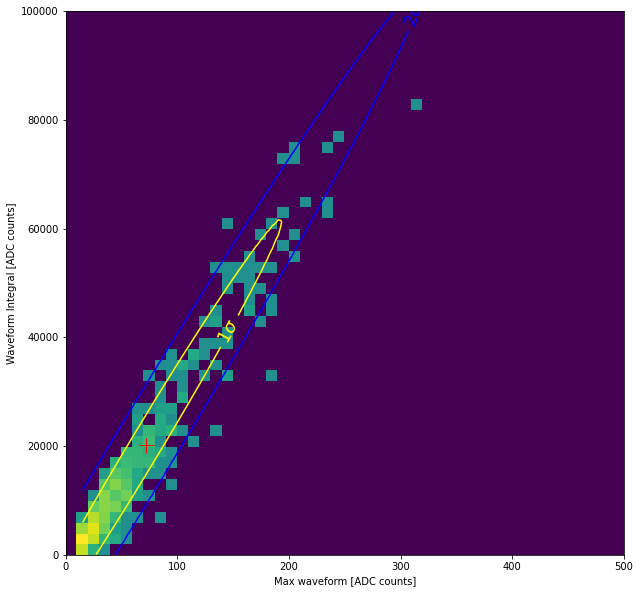

In [21]:
mu, cov = estimate_gaus_param(X,True)


plt.figure(figsize=(10,10))

plt.plot(mu[0], mu[1], marker='+', ms=15, c='red')

plt.hist2d( X[:,0] , X[:,1], 
           [50,50],
           range=[[0,500],[0,100000]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))


plt.xlabel('Max waveform [ADC counts]')
plt.ylabel('Waveform Integral [ADC counts]')


plot_contours(X, mu, cov)
plt.show()

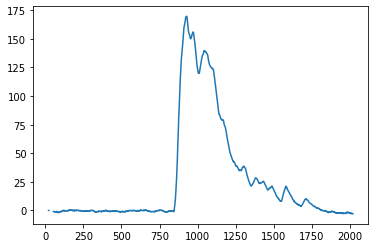

In [159]:
df_ch0.iloc[106,rowin].plot()

In [153]:
df_tmp.loc[ (df_tmp['max'] >150 ) & (df_tmp['Integral'] > 40000 )]


,Ch,Run number,Evt number,0,1,2,3,4,5,6,...,2023,Saturated,Pedestal,hasSignal,n pe,pe height,pe width,pe area,max,Integral
0,0,11099,4,11099.0,1.0,4.0,603.0,48.0,0.0,264.0,...,2.880000,False,1577.92,True,0.0,0.000000,0.000000,0.000000,213.580000,72922.846667
5,0,11099,24,11099.0,1.0,24.0,603.0,48.0,0.0,264.0,...,-0.093333,False,1577.56,True,0.0,0.000000,0.000000,0.000000,375.340000,126684.373333
21,0,11099,88,11099.0,1.0,88.0,603.0,48.0,0.0,264.0,...,13.420000,False,1577.48,True,0.0,0.000000,0.000000,0.000000,612.953333,206928.286667
33,0,11099,142,11099.0,1.0,142.0,603.0,48.0,0.0,264.0,...,-2.036667,False,1577.57,True,0.0,0.000000,0.000000,0.000000,166.630000,43572.663333
62,0,11099,253,11099.0,1.0,253.0,603.0,48.0,0.0,264.0,...,-0.723333,False,1576.99,True,0.0,0.000000,0.000000,0.000000,174.576667,52044.176667
106,0,11099,441,11099.0,1.0,441.0,603.0,48.0,0.0,264.0,...,-2.993333,False,1578.26,True,0.0,0.000000,0.000000,0.000000,169.740000,51963.573333
180,0,11099,729,11099.0,1.0,729.0,603.0,48.0,0.0,264.0,...,-2.353333,False,1577.22,True,0.0,0.000000,0.000000,0.000000,232.413333,60304.646667
203,0,11099,835,11099.0,1.0,835.0,603.0,48.0,0.0,264.0,...,-1.130000,False,1577.53,True,1.0,9.036667,61.833333,420.773333,1004.436667,310320.770000
213,0,11099,875,11099.0,1.0,875.0,603.0,48.0,0.0,264.0,...,-3.410000,False,1578.21,True,0.0,0.000000,0.000000,0.000000,219.590000,71973.056667
297,0,11099,1203,11099.0,1.0,1203.0,603.0,48.0,0.0,264.0,...,-19.720000,False,1576.22,True,0.0,0.000000,0.000000,0.000000,1487.280000,531151.946667


## Check selected single pe  

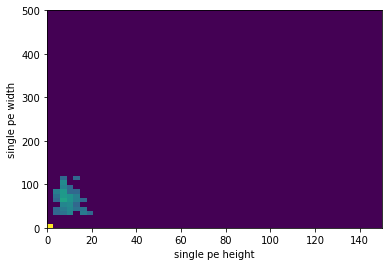

In [20]:
plt.hist2d(df_tmp['pe height'], df_tmp['pe width'], 
           [50,50], range=[[0,150],[0,500]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))
plt.xlabel('single pe height')
plt.ylabel('single pe width')

plt.show()


In [16]:
X_pe=df_tmp.loc[(df_tmp['pe height']>0)&
      (df_tmp['pe width']>0),['pe height', 'pe width']].values

In [17]:
def plot_contours_pe(X, mean, cov):
    
    X1range = np.arange(np.min(X[:,0]),np.max(X[:,0]),0.1)
    X2range = np.arange(np.min(X[:,1]),np.max(X[:,1]),0.1)

    X1mesh, X2mesh = np.meshgrid(X1range, X2range)
    
    coord_list = [ np.array([X0,X1]) for X0, X1 in zip(np.ravel(X1mesh), np.ravel(X2mesh)) ]
    Z = multivariate_normal.pdf( coord_list , mean=mean, cov=cov)
    Z = Z.reshape(X1mesh.shape)
    
    #cont_levels = [10**exp for exp in range(-50,0,3)]
    sigma = np.sqrt(np.diag(cov))
    nsigma = np.array([mu+n*sigma for n in range(1,3)[::-1]])
    
    cont_levels = multivariate_normal.pdf( nsigma , mean=mu, cov=cov)    
    cs = plt.contour(X1mesh, X2mesh, Z, 10, levels=cont_levels, colors=('blue', 'yellow', 'orange', 'red' ))
   
    #plt.clabel(cs, fmt='%g', inline=1, fontsize=10)

    fmt = {}
    strs = ['$1 \sigma$', '$2 \sigma$', '$3 \sigma$', '$4 \sigma$', '$5 \sigma$', '$6 \sigma$', '$7 \sigma$']
    for l, s in zip(cs.levels[::-1], strs):
        fmt[l] = s

    # Label every other level using strings
    plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=18)

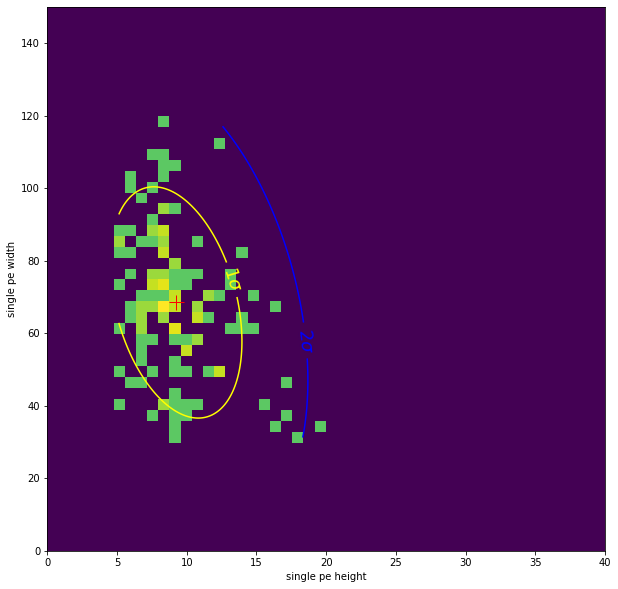

In [19]:
mu_pe, cov_pe = estimate_gaus_param(X_pe,True)


plt.figure(figsize=(10,10))

plt.plot(mu_pe[0], mu_pe[1], marker='+', ms=15, c='red')

plt.hist2d( X_pe[:,0] , X_pe[:,1], 
           [50,50],
           range=[[0,40],[0, 150]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))

plt.xlabel('single pe height')
plt.ylabel('single pe width')

plot_contours_pe(X_pe, mu_pe, cov_pe)

plt.show()

In [23]:
def select_wf(xy, mean, cov, n_sigma):
 
    Z = multivariate_normal.pdf( xy , mean=mean, cov=cov)
    #print(Z)
    
    sigma = np.sqrt(np.diag(cov))
    limit = n_sigma * sigma     
        
    thrsld = multivariate_normal.pdf( limit, mean=mu, cov=cov)
    #print(thrsld)
    
    return Z > thrsld

In [24]:
df_tmp['spe 1sig'] = df_tmp.apply(lambda x: select_wf(x[['pe height','pe width']], mu_pe, cov_pe, 1), axis=1)
df_tmp.head()

,Ch,Run number,Evt number,0,1,2,3,4,5,6,...,Saturated,Pedestal,hasSignal,n pe,pe height,pe width,pe area,max,Integral,spe 1sig
52,0,11103,8205,11103.0,1.0,8205.0,603.0,48.0,0.0,264.0,...,False,1577.39,True,0.0,0.0,0.0,0.0,18.376667,4100.710000,True
53,0,11103,8207,11103.0,1.0,8207.0,603.0,48.0,0.0,264.0,...,False,1578.45,True,0.0,0.0,0.0,0.0,70.550000,18544.083333,True
65,0,11103,8251,11103.0,1.0,8251.0,603.0,48.0,0.0,264.0,...,False,1577.96,True,0.0,0.0,0.0,0.0,46.340000,13146.773333,True
67,0,11103,8255,11103.0,1.0,8255.0,603.0,48.0,0.0,264.0,...,False,1578.60,True,0.0,0.0,0.0,0.0,16.300000,824.900000,True
68,0,11103,8257,11103.0,1.0,8257.0,603.0,48.0,0.0,264.0,...,False,1577.37,True,0.0,0.0,0.0,0.0,21.330000,7540.163333,True


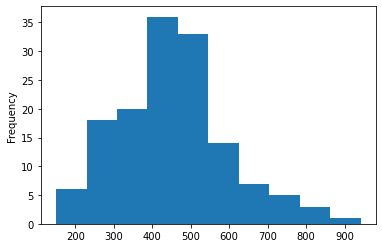

In [32]:
df_tmp.loc[(df_tmp['spe 1sig']==True) & (df_tmp['pe width']>0 )  & (df_tmp['pe height']>0 )]['pe area'].plot(kind='hist')

In [208]:
def do_average_singlepe(dflist):
    df_av_spe = []
    
    for df in dflist:

        df_tmp = df.loc[ (df['n pe'] >0) ].groupby(['Run number', 'Ch'])['pe area'].mean() 
        
        df_av_spe.append(df_tmp)
       
   
    return pd.concat(df_av_spe)

In [245]:
df_average_spe = do_average_singlepe(df_list_proc).to_frame()
df_average_spe.reset_index(inplace = True)
tmp = df_average_spe.pivot(index='Run number', columns='Ch', values='pe area')
tmp
df_calib = tmp.div(tmp[0], axis = 0)
df_calib

Ch,0,1,2,3,4,5,6,7,8,9,10,11
Run number,,,,,,,,,,,,
11099,1.0,1.075630,1.018810,0.978745,1.056059,0.932960,0.941649,1.022839,0.917949,1.032745,0.994247,0.986184
11102,1.0,1.014482,1.003572,0.936137,1.004916,0.889312,0.867152,0.982666,0.945255,1.031743,0.979050,0.999420
11107,1.0,0.993875,0.957320,0.968172,1.024213,0.909203,0.924718,0.982101,0.931540,0.996731,1.012577,0.973854


In [219]:
df_calib_2 = df_calib.T.stack(level=0).to_frame(name='f_cal').reset_index()
df_calib_2.head()

,Ch,Run number,f_cal
0,0,11099,1.000000
1,0,11102,1.000000
2,0,11107,1.000000
3,1,11099,1.075630
4,1,11102,1.014482


In [221]:
df_av_wf.head()

,Run number,Ch,700,701,702,703,704,705,706,707,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,11099,0,0.720714,0.712656,0.707070,0.708077,0.705788,0.712289,0.726117,0.718608,...,0.833535,0.837289,0.826484,0.815311,0.805421,0.780604,0.755055,0.733352,0.738388,0.714945
1,11102,0,0.580272,0.604137,0.605953,0.607769,0.627873,0.630856,0.638249,0.653424,...,0.118664,0.118275,0.106213,0.102711,0.111012,0.123852,0.138379,0.151089,0.167302,0.164189
2,11107,0,0.559635,0.569529,0.568280,0.572411,0.553967,0.536964,0.538117,0.535043,...,0.499885,0.494697,0.503631,0.517080,0.516503,0.521114,0.518617,0.528223,0.517656,0.513237
3,11099,1,1.100486,1.109258,1.103118,1.101603,1.103437,1.099211,1.107663,1.117073,...,0.891874,0.890598,0.878876,0.866276,0.848094,0.825925,0.813565,0.795861,0.783501,0.782943
4,11102,1,0.582535,0.565289,0.566215,0.555914,0.544225,0.530220,0.529294,0.522581,...,0.254178,0.246771,0.235891,0.214711,0.194456,0.189479,0.183808,0.162396,0.163437,0.153831


In [222]:
df_average_spe.head()

,Run number,Ch,pe area
0,11099,0,429.776489
1,11102,0,443.448819
2,11107,0,447.963273
3,11099,1,462.280681
4,11102,1,449.870714


Run number
11099     817.050888
11102     892.578466
11107    1102.093992
dtype: float64


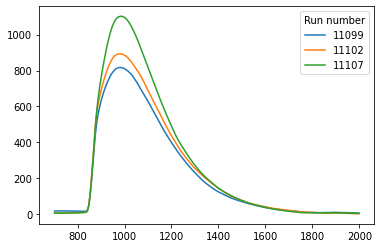

In [255]:
df_wf_raw = df_av_wf.groupby(['Run number']).sum().T
print(df_wf_raw[3:1300].max(axis=0) )
df_wf_raw[3:1300].plot()